<a href="https://colab.research.google.com/github/geophase/Machine-Learning-on-Classical-and-Quantum-Data-Photonics-MSc-/blob/main/AnalysingMLModelsExercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import io
#from skimage import io
import io
import requests
from PIL import Image
from google.colab.patches import cv2_imshow # for image display
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pdb

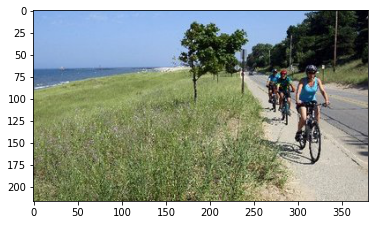

In [ ]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

# print the input image
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
plt.imshow(img_pil)

In [ ]:
# Let's decide on the model first. Maybe print it out so we see the architecture.
# Remember, for the basic CAM, the global average pooling (GAP) is needed! Every feature map has to have only one value in the fully-connected layer!
# networks such as GoogleNet, ResNet, DenseNet already use global average pooling at the end, so CAM could be used directly.
# You can look at them here: https://neurohive.io/en/popular-networks/
model_id = 2 # 1 = SqueezeNet, 2 = ResNet18, 3 = DenseNet161
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#print(net)

In [ ]:
# Set the pre-trained network to evaluation mode
net.eval()

In [ ]:
# Hook the feature extractor. It means that now will be following what gets activated in the last convolutional layer.
# So when we finally make a prediction on the test image with our model, this hook will contain the activated features.
# The name of the last convolutional layer depend on the model we chose. In the cell where we did that, we also defined 'finalconv_name'.
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [ ]:
# Get the softmax weight (on the side of GAP, therefore 'params[-2]', so second from the end), so we take these single values to which every feature maps collapsed when we applied GAP.
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [ ]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [ ]:
# To classify an arbitrary image, we need to do some preprocessing to it before inputting to the model.
# Namely: (1) Resize to (224, 224) so it fits the input size of our network.
# (2) Transform the data into the format called "Tensor" which is used by PyTorch.
# (3) Normalize the image accordingly to the mean and standard deviation of the training data in ImageNet dataset .

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize])

In [ ]:
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

# Finally, the prediction! Hook attached to the final convolutional layer will remember the activated features.
logit = net(img_variable)

In [ ]:
# We got the predictions for all labels, but now we need to (1) put it through the softmax function, (2) find the largest value, (3) find to which label it corresponds to!

# Download the imagenet category list:
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

# We put the logit through the softmax:
h_x = F.softmax(logit, dim=1).data.squeeze()

# We sort the probabilities along with the corresponding labels
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# Output the prediction (so here 5 labels with the highest probabilities)
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

In [ ]:
# Finally, we can generate class activation mapping for the any class prediction.
# Let's start with the class with the highest probability, so top1: idx[0] (we sorted it accordingly to the probabilities, remmember?)
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

In [ ]:
# Render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread(folder + 'test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite(folder + 'CAM.jpg', result)
cv2_imshow(result) # Colab and cv2.imshow() don't work, that's why we imported a patch with cv2_imshow